<a href="https://colab.research.google.com/github/andonyns/air-quality/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 01

## Grupo 04
- Jorge Ignacio Chavarría Herrera - B82073
- Antonio Badilla-Olivas - B80874
- Enrique Guillermo Vílchez Lizano - C18477
- Andony Nuñez Solano - B04539

## Objetivos

1. Selección y recolección de parámetros y ciudades.
2. Limpiar y transformar los datos para comparaciones.
3. Análisis univariable y multivariable. Analizar las tendencias de los indicadores y hacer comparaciones. Incluir posibles correlaciones entre variables.
4. Conclusiones y recomendaciones según las políticas ambientales de cada país.

# Relevant concepts
These are the variables that [OpenAQ](https://openaq.org/) offers to measure air pollution. The definitions were taken from [Clean Air Act](https://www.epa.gov/criteria-air-pollutants/information-pollutant):

1. PM (Particular Matter): These particles come in many sizes and shapes and can be made up of hundreds of different chemicals. Some are emitted directly from a source, such as construction sites, unpaved roads, fields, smokestacks or fires. Most particles form in the atmosphere as a result of complex reactions of chemicals such as sulfur dioxide and nitrogen oxides, which are pollutants emitted from power plants, industries and automobiles.

  - PM₂.₅ (Particulate Matter 2.5 micrometers or smaller):
fine inhalable particles, with diameters that are generally 2.5 micrometers and smaller

  - PM₁₀ (Particulate Matter 10 micrometers or smaller):
inhalable particles, with diameters that are generally 10 micrometers and smaller

2.	O₃ (Ozone):
tropospheric, or ground level ozone, is not emitted directly into the air, but is created by chemical reactions between oxides of nitrogen (NOx) and volatile organic compounds (VOC). This happens when pollutants emitted by cars, power plants, industrial boilers, refineries, chemical plants, and other sources chemically react in the presence of sunlight.

3.	NO₂ (Nitrogen Dioxide):
Nitrogen Dioxide (NO2) is one of a group of highly reactive gases known as oxides of nitrogen or nitrogen oxides (NOx). Other nitrogen oxides include nitrous acid and nitric acid. NO2 is used as the indicator for the larger group of nitrogen oxides. NO2 primarily gets in the air from the burning of fuel. NO2 forms from emissions from cars, trucks and buses, power plants, and off-road equipment.

4.	SO₂ (Sulfur Dioxide):
SO2 is the component of greatest concern and is used as the indicator for the larger group of gaseous sulfur oxides (SOx).  Other gaseous SOx (such as SO3) are found in the atmosphere at concentrations much lower than SO2. The largest source of SO2 in the atmosphere is the burning of fossil fuels by power plants and other industrial facilities. Smaller sources of SO2 emissions include: industrial processes such as extracting metal from ore; natural sources such as volcanoes; and locomotives, ships and other vehicles and heavy equipment that burn fuel with a high sulfur content.

5.	CO (Carbon Monoxide):
CO is a colorless, odorless gas that can be harmful when inhaled in large amounts. CO is released when something is burned. The greatest sources of CO to outdoor air are cars, trucks and other vehicles or machinery that burn fossil fuels. A variety of items in your home such as unvented kerosene and gas space heaters, leaking chimneys and furnaces, and gas stoves also release CO and can affect air quality indoors.

In [46]:
%pip install dotenv
%pip install openaq

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [107]:
# For API requests
import requests
from urllib.parse import urljoin
from openaq import OpenAQ

# For env
import os
from dotenv import load_dotenv

# For data manipulation
from pprint import pprint
import pandas as pd
import pickle as pkl

import time
import logging
import sys

from dataclasses import dataclass
import re

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns



2025-04-22 22:40:01 - matplotlib.font_manager - INFO - generated new fontManager


### Funciones de ayuda

In [48]:
def set_color(text: str, color: str = "green") -> str:
    """
    Set the color of the text.
    :param text: The text to color.
    :param color: The color to set.
    :return: The colored text.
    """
    colors = {
        "green": "\033[32m",
        "yellow": "\033[33m",
        "red": "\033[31m",
        "blue": "\033[34m",
        "orange": "\033[38;5;214m",
        "reset": "\033[0m",
    }
    return f"{colors[color]}{text}{colors['reset']}"

class StdOutLogger(logging.Logger):
    def __init__(self):
        super().__init__(__name__)
        self.logger = logging.getLogger(__name__)
        # To log events
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S',
            stream=sys.stdout
        )

    def info(self, message: str):
        self.logger.info(set_color(message, "blue"))
        
    def success(self, message: str):
        self.logger.info(set_color(message, "green"))

    def warning(self, message: str):
        self.logger.warning(set_color(message, "orange"))

    def critical(self, message: str):
        self.logger.critical(set_color(message, "red"))


Instanciamos un logger y cargamos las variables de ambiente para obtener API_KEY.

In [49]:
# Load logger
logger = StdOutLogger()

# Load environment variables
load_dotenv()

True

### Constantes

In [50]:
DATA_DIR = "data"
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

BASE_API_URL = "https://api.openaq.org/v3/"

HEADERS = {"X-API-Key": os.getenv("API_KEY")}

LOCATIONS_ENDPOINT = urljoin(BASE_API_URL, "locations/{location_id}")
MEASUREMENTS_ENDPOINT = urljoin(BASE_API_URL, "sensors/{sensor_id}/measurements/daily")

### Funcion para obtener datos

Ahora, creamos una función para obtener datos del API, que permite agregar parámetros de la ruta.

In [51]:
def fetch_data(
    base_url: str,
    headers: dict[str, str] | None = None,
    parameters: dict[str, any] | None = None,
    query_parameters: dict[str, any] | None = None,
    verbose: bool = False
):
    """
    Fetch data from the OpenAQ API.
    :param base_url: The base URL for the API endpoint.
    :param headers: Optional headers to include in the request.
    :param parameters: Optional parameters to format the URL.
    :param query_parameters: Optional query parameters to include in the request.
    :param verbose: If True, print the response headers.
    :return: The JSON response from the API.
    """

    
    if parameters is not None:
        base_url = base_url.format(**parameters)

    if query_parameters is not None:
        base_url = urljoin(base_url, "?" + "&".join(f"{k}={v}" for k, v in query_parameters.items()))

    if headers is not None:
        response = requests.get(
            url=base_url,
            headers=headers,
        )
    else:
        response = requests.get(
            url=base_url,
        )

    if response.status_code != 200:
        raise Exception(
            f"Request failed with status: {response.status_code}. Reason: {response.text}"
        )
    if verbose:
        pprint(response.headers)
    return response

### Ejemplo de CR

Podemos jalar los datos de una localización llamando a la función y accediendo al endpoint de las localizaciones. De antemano, se buscó el ID de la localización existente en [Explore the data](https://explore.openaq.org/#1.2/20/40). Así se usa esto como parámetro para obtener la información de la localización.

In [52]:
# Costa Rica example
cr_location_id = 3070644

cr_location_data = fetch_data(
    base_url=LOCATIONS_ENDPOINT,
    headers=HEADERS,
    parameters={"location_id": cr_location_id},
).json()
pprint(cr_location_data)

{'meta': {'found': 1,
          'limit': 100,
          'name': 'openaq-api',
          'page': 1,
          'website': '/'},
 'results': [{'bounds': [-84.0417, 9.938, -84.0417, 9.938],
              'coordinates': {'latitude': 9.938, 'longitude': -84.0417},
              'country': {'code': 'CR', 'id': 29, 'name': 'Costa Rica'},
              'datetimeFirst': {'local': '2024-09-19T14:01:34-06:00',
                                'utc': '2024-09-19T20:01:34Z'},
              'datetimeLast': {'local': '2025-04-22T12:55:50-06:00',
                               'utc': '2025-04-22T18:55:50Z'},
              'distance': None,
              'id': 3070644,
              'instruments': [{'id': 4, 'name': 'Clarity Sensor'}],
              'isMobile': False,
              'isMonitor': False,
              'licenses': [{'attribution': {'name': 'Clarity', 'url': None},
                            'dateFrom': '2021-10-20',
                            'dateTo': None,
                            'id

Específicamente, este endpoint extrae, entre otras cosas, la información de los sensores que toman datos allí. Con esta información es posible obtener la información de los datos que han medido los sensores a través del tiempo.

En este caso, y a modo de ejemplo, vamos a obtener la información del primer sensor de Costa Rica.

In [53]:
# Get the first sensor
sensor = cr_location_data["results"][0]["sensors"][0]
not_finished = True
query_params = {"limit": 1000, "page": 1}

while not_finished: 
    sensor_id = sensor["id"]
    sensor_data = fetch_data(
        base_url=MEASUREMENTS_ENDPOINT,
        headers=HEADERS,
        parameters={"sensor_id": sensor_id},
        query_parameters=query_params,
    ).json()
    if len(sensor_data["results"]) < 1000:
        print(f"last page: {sensor_data["meta"]["page"]}")
        not_finished = False

    else:
        query_params["page"] += 1

print(f"Total pages: {query_params["page"]}")

last page: 1
Total pages: 1


Agrupando las mediciones por día, se obtiene una granularidad decente para el análisis de los datos, pues muchos países no tiene una única página de datos como Costa Rica, si no que tiene muchísimas páginas más.

Vamos a hacer una función para obtener la información de todas las páginas de medidas que arroja el endpoint.

In [54]:
def fetch_location_sensors_data(
    location_id: int,
):
    logger.info(f"Fetching data for location ID: {location_id}...")
    location_data = fetch_data(
        base_url=LOCATIONS_ENDPOINT,
        headers=HEADERS,
        parameters={"location_id": location_id},
    ).json()

    logger.success(f"Finished fetch for data of location ID: {location_id}")

    # Get all sensors info
    sensors_data = {}
    

    # Iterate through all sensors
    for i, sensor in enumerate(location_data["results"][0]["sensors"]):
        query_params = {"limit": 100, "page": 1}
        logger.info(f"Processing sensor number {i}")
        sensor_id = sensor["id"]
        sensors_data[sensor_id] = []

        not_finished = True
        while not_finished:


            sensor_response = fetch_data(
                base_url=MEASUREMENTS_ENDPOINT,
                headers=HEADERS,
                parameters={"sensor_id": sensor_id},
                query_parameters=query_params,
            )

            sensor_data = sensor_response.json()

            logger.info(f"Processing sensor number {i}, page {sensor_data["meta"]["page"]}")
            logger.warning(f"Remaining requests: {sensor_response.headers["X-Ratelimit-Remaining"]}")
            
            sensors_data[sensor_id].append(sensor_data)  

            if len(sensor_data["results"]) < 100:
                not_finished = False
            else:
                query_params["page"] += 1
            
            if (sensor_response.headers["X-Ratelimit-Remaining"] == "1"):
                logger.warning(f"Reached rate limit. Waiting for {sensor_response.headers["X-Ratelimit-Reset"]} seconds.")
                time.sleep(int(sensor_response.headers["X-Ratelimit-Reset"]))

        logger.success(f"Finished processing sensor number {i}")

    logger.success(f"Finished processing all sensors for location ID: {location_id}")
    return sensors_data

### Obtención de datos de todas las localizaciones

Por comodidad, también podemos hacer una clase localización, que guarde datos básicos de ella y además los datos de sus sensores.

In [72]:
class Location:
    def __init__(self, country: str, name: str, id: int, sensors_data: dict = None):
        self.country: str = country
        self.name: str = name
        self.id: int = id
        self.sensors_data: dict = sensors_data
        self.file_path: str = f"{DATA_DIR}/{country}_{name}/{country}_{name}"

    def pull_sensors_data(self):
        self.sensors_data = fetch_location_sensors_data(self.id)
    
    @staticmethod
    def save(location: "Location"):
        if not os.path.isdir(DATA_DIR + f"/{location.country}_{location.name}"):
            os.mkdir(DATA_DIR + f"/{location.country}_{location.name}")

        with open(f"{location.file_path}.pkl", "wb") as f:
            pkl.dump(location, f)

    @staticmethod
    def load(location: "Location") -> "Location":
        with open(f"{location.file_path}.pkl", "rb") as f:
            location = pkl.load(f)
        
        return location
    

In [56]:
locations = [
    Location(country="Costa Rica", name="NASA GSFC Rutgers Calib. N13", id=3070644),
    Location(country="Spain", name="Escaldes-Engordany", id=9742)
]

Vamos a jalar los datos agrupados por día para cada localización. Sería posible obtener cada una de las mediciones individuales, sin embargo, el endpoint no está optimizado para que le soliciten tantas páginas. Mientras más alto es el número de página que se le solicita, más lenta va a ser la respuesta. El servidor mata la solicitud si tarda demasiado. Véase acá un ejemplo:

In [67]:
MEASUREMENTS_ENDPOINT = urljoin(BASE_API_URL, "sensors/{sensor_id}/measurements")

# For every location, save all info
for location in locations:
    location.pull_sensors_data()
    Location.save(location)
    
    del location.sensors_data
    
    logger.success(f"Saved data for location {location.name}")

2025-04-22 21:14:10 - __main__ - INFO - Fetching data for location ID: 3070644...
2025-04-22 21:14:10 - __main__ - INFO - Finished fetch for data of location ID: 3070644
2025-04-22 21:14:10 - __main__ - INFO - Processing sensor number 0
2025-04-22 21:14:10 - __main__ - INFO - Processing sensor number 0, page 1
2025-04-22 21:14:10 - __main__ - WARNING - Remaining requests: 58
2025-04-22 21:14:10 - __main__ - INFO - Processing sensor number 0, page 2
2025-04-22 21:14:10 - __main__ - WARNING - Remaining requests: 57
2025-04-22 21:14:11 - __main__ - INFO - Processing sensor number 0, page 3
2025-04-22 21:14:11 - __main__ - WARNING - Remaining requests: 56
2025-04-22 21:14:11 - __main__ - INFO - Processing sensor number 0, page 4
2025-04-22 21:14:11 - __main__ - WARNING - Remaining requests: 55
2025-04-22 21:14:11 - __main__ - INFO - Processing sensor number 0, page 5
2025-04-22 21:14:11 - __main__ - WARNING - Remaining requests: 54
2025-04-22 21:14:12 - __main__ - INFO - Processing sensor 

Exception: Request failed with status: 408. Reason: {"detail":"Connection timed out: Try to provide more specific query parameters or a smaller time frame."}

Por lo tanto, se prefirió hacer las solicitudes agrupadas por día, que todavía son suficientemente representativas.

In [68]:
MEASUREMENTS_ENDPOINT = urljoin(BASE_API_URL, "sensors/{sensor_id}/measurements/daily")

# For every location, save all info
for location in locations:
    location.pull_sensors_data()
    Location.save(location)
    
    del location.sensors_data
    
    logger.success(f"Saved data for location {location.name}")

2025-04-22 21:37:32 - __main__ - INFO - Fetching data for location ID: 3070644...
2025-04-22 21:37:32 - __main__ - INFO - Finished fetch for data of location ID: 3070644
2025-04-22 21:37:32 - __main__ - INFO - Processing sensor number 0
2025-04-22 21:37:33 - __main__ - INFO - Processing sensor number 0, page 1
2025-04-22 21:37:33 - __main__ - WARNING - Remaining requests: 58
2025-04-22 21:37:33 - __main__ - INFO - Processing sensor number 0, page 2
2025-04-22 21:37:33 - __main__ - WARNING - Remaining requests: 57
2025-04-22 21:37:33 - __main__ - INFO - Finished processing sensor number 0
2025-04-22 21:37:33 - __main__ - INFO - Finished processing all sensors for location ID: 3070644
2025-04-22 21:37:33 - __main__ - INFO - Saved data for location NASA GSFC Rutgers Calib. N13
2025-04-22 21:37:33 - __main__ - INFO - Fetching data for location ID: 9742...
2025-04-22 21:37:33 - __main__ - INFO - Finished fetch for data of location ID: 9742
2025-04-22 21:37:33 - __main__ - INFO - Processing 


# 2. Tareas de limpieza y transformación:

Se deben realizar las tareas de limpieza y transformación necesarias para poder hacer un comparativo de la evolución de los diferentes indicadores de la calidad del aire en Costa Rica y las otras ciudades.


In [70]:
# Load the data
locations = [Location.load(location) for location in locations]


### Paso a csv

Primero, vamos a eliminar los datos que no interesan y quedarnos con los que son relevantes para hacer análisis

In [75]:
def location_to_pd(
    location_data: Location
) -> pd.DataFrame:
    
    """
    Clean the sensors data.
    :param sensors_data: The sensors data to clean.
    :return: The cleaned sensors data.
    """
    rows = []

    for sensor_id, sensor_data in location_data.sensors_data.items():
        for page in sensor_data:
            for measurement in page["results"]:
                rows.append([
                    location_data.id,
                    location.country + " " + location_data.name,
                    sensor_id,
                    measurement["period"]["datetimeFrom"]["utc"],
                    measurement["period"]["datetimeTo"]["utc"],
                    measurement["parameter"]["name"],
                    measurement["parameter"]["units"],
                    measurement["value"],
                    measurement["coverage"]["observedCount"],
                    measurement["summary"]["avg"],
                    measurement["summary"]["max"],
                    measurement["summary"]["median"],
                    measurement["summary"]["min"],
                    measurement["summary"]["q02"],
                    measurement["summary"]["q25"],
                    measurement["summary"]["q75"],
                    measurement["summary"]["q98"],
                    measurement["summary"]["sd"]
                ])

    # Create DataFrame all at once
    return pd.DataFrame(rows, columns=[
        "location_id",
        "location_name",
        "sensor_id",
        "from_date",
        "to_date",
        "parameter_name",
        "parameter_units",
        "value",
        "aggregated_count",
        "summary_avg",
        "summary_max",
        "summary_median",
        "summary_min",
        "summary_q02",
        "summary_q25",
        "summary_q75",
        "summary_q98",
        "summary_sd"
    ])

In [76]:
for location in locations:
    df = location_to_pd(location)
    df.to_csv(f"{location.file_path}.csv", index=False)

In [77]:
locations_dfs = [pd.read_csv(f"{location.file_path}.csv") for location in locations]

### Descripción de los datos

Veamos si hay valores nulos en alguno de los data frames.

In [84]:
for df, location in zip(locations_dfs, locations):
    logger.info(f"Location: {location.country} {location.name}")
    logger.info(f"DataFrame null values: {df.isnull().sum()}")

2025-04-22 21:59:05 - __main__ - INFO - Location: Costa Rica NASA GSFC Rutgers Calib. N13
2025-04-22 21:59:05 - __main__ - INFO - DataFrame null values: location_id         0
location_name       0
sensor_id           0
from_date           0
to_date             0
parameter_name      0
parameter_units     0
value               0
aggregated_count    0
summary_avg         0
summary_max         0
summary_median      0
summary_min         0
summary_q02         0
summary_q25         0
summary_q75         0
summary_q98         0
summary_sd          0
dtype: int64
2025-04-22 21:59:05 - __main__ - INFO - Location: Spain Escaldes-Engordany
2025-04-22 21:59:05 - __main__ - INFO - DataFrame null values: location_id           0
location_name         0
sensor_id             0
from_date             0
to_date               0
parameter_name        0
parameter_units       0
value                 0
aggregated_count      0
summary_avg           0
summary_max           0
summary_median        0
summary_min 

Aparentemente hay valores nulos en el campo de "sd". Estos son datos en donde el proceso de agregado solo tenía un elemento, por lo que no hay una desviación estándar para los datos de ese día. Esto no es preocupante, pero se deben cambiar estos datos a un 0.

In [88]:
for df in locations_dfs:
    df["summary_sd"] = df["summary_sd"].replace(value=0, to_replace=pd.NA)

/tmp/ipykernel_3758/2311568736.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["summary_sd"] = df["summary_sd"].replace(value=0, to_replace=pd.NA)


Verifiquemos nuevamente la cantidad de nulos.

In [101]:
for df, location in zip(locations_dfs, locations):
    logger.info(f"Location: {location.country} {location.name}")
    logger.info(f"DataFrame null values: \n{df.isnull().sum()}")

2025-04-22 22:26:16 - __main__ - INFO - Location: Costa Rica NASA GSFC Rutgers Calib. N13
2025-04-22 22:26:16 - __main__ - INFO - DataFrame null values: 
location_id         0
location_name       0
sensor_id           0
from_date           0
to_date             0
parameter_name      0
parameter_units     0
value               0
aggregated_count    0
summary_avg         0
summary_max         0
summary_median      0
summary_min         0
summary_q02         0
summary_q25         0
summary_q75         0
summary_q98         0
summary_sd          0
dtype: int64
2025-04-22 22:26:16 - __main__ - INFO - Location: Spain Escaldes-Engordany
2025-04-22 22:26:16 - __main__ - INFO - DataFrame null values: 
location_id           0
location_name         0
sensor_id             0
from_date             0
to_date               0
parameter_name        0
parameter_units       0
value                 0
aggregated_count      0
summary_avg           0
summary_max           0
summary_median        0
summary_mi

Hemos limpiado los datos y están listos para el análisis.

In [90]:
for df, location in zip(locations_dfs, locations):
    df.to_csv(f"{location.file_path}_cleaned.csv", index=False)

Veamos la cantidad de datos en cada localización.

In [102]:
for df, location in zip(locations_dfs, locations):
    logger.info(f"Location: {location.country} {location.name}")
    logger.info(f"DataFrame shape: {df.shape}")

2025-04-22 22:26:23 - __main__ - INFO - Location: Costa Rica NASA GSFC Rutgers Calib. N13
2025-04-22 22:26:23 - __main__ - INFO - DataFrame shape: (199, 18)
2025-04-22 22:26:23 - __main__ - INFO - Location: Spain Escaldes-Engordany
2025-04-22 22:26:23 - __main__ - INFO - DataFrame shape: (13609, 18)


También, podemos ver los datos en cada columna.

In [103]:
for df, location in zip(locations_dfs, locations):
    logger.info(f"Location: {location.country} {location.name}")
    logger.info(f"Info: \n{df.info()}")

2025-04-22 22:26:25 - __main__ - INFO - Location: Costa Rica NASA GSFC Rutgers Calib. N13
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   location_id       199 non-null    int64  
 1   location_name     199 non-null    object 
 2   sensor_id         199 non-null    int64  
 3   from_date         199 non-null    object 
 4   to_date           199 non-null    object 
 5   parameter_name    199 non-null    object 
 6   parameter_units   199 non-null    object 
 7   value             199 non-null    float64
 8   aggregated_count  199 non-null    int64  
 9   summary_avg       199 non-null    float64
 10  summary_max       199 non-null    float64
 11  summary_median    199 non-null    float64
 12  summary_min       199 non-null    float64
 13  summary_q02       199 non-null    float64
 14  summary_q25       199 non-null    float64
 15  s

Por último, podemos describir los datos numéricos en cada data frame.

In [104]:
for df, location in zip(locations_dfs, locations):
    logger.info(f"Location: {location.country} {location.name}")
    logger.info(f"Description: \n{df.describe()}")

2025-04-22 22:26:28 - __main__ - INFO - Location: Costa Rica NASA GSFC Rutgers Calib. N13
2025-04-22 22:26:28 - __main__ - INFO - Description: 
       location_id   sensor_id       value  aggregated_count  summary_avg  \
count        199.0       199.0  199.000000        199.000000   199.000000   
mean     3070644.0  10669679.0    6.076834         62.467337     6.076642   
std            0.0         0.0    1.360798         14.617261     1.360336   
min      3070644.0  10669679.0    4.010000          4.000000     4.005652   
25%      3070644.0  10669679.0    5.175000         55.000000     5.175235   
50%      3070644.0  10669679.0    5.740000         64.000000     5.744658   
75%      3070644.0  10669679.0    6.655000         73.000000     6.651871   
max      3070644.0  10669679.0   12.400000         82.000000    12.368167   

       summary_max  summary_median  summary_min  summary_q02  summary_q25  \
count   199.000000      199.000000   199.000000   199.000000   199.000000   
mean    

In [105]:
for df, location in zip(locations_dfs, locations):
    logger.info(f"Location: {location.country} {location.name}")
    logger.info(f"Parameters measured in location: \n{df[["parameter_name", "parameter_units"]].drop_duplicates()}")

2025-04-22 22:26:32 - __main__ - INFO - Location: Costa Rica NASA GSFC Rutgers Calib. N13
2025-04-22 22:26:32 - __main__ - INFO - Parameters measured in location: 
  parameter_name parameter_units
0           pm25           µg/m³
2025-04-22 22:26:32 - __main__ - INFO - Location: Spain Escaldes-Engordany
2025-04-22 22:26:32 - __main__ - INFO - Parameters measured in location: 
      parameter_name parameter_units
0                 co           µg/m³
2329              no           µg/m³
2655             no2           µg/m³
5226              o3           µg/m³
7794            pm10           µg/m³
10349           pm25           µg/m³
11040            so2           µg/m³


### Análisis univariable

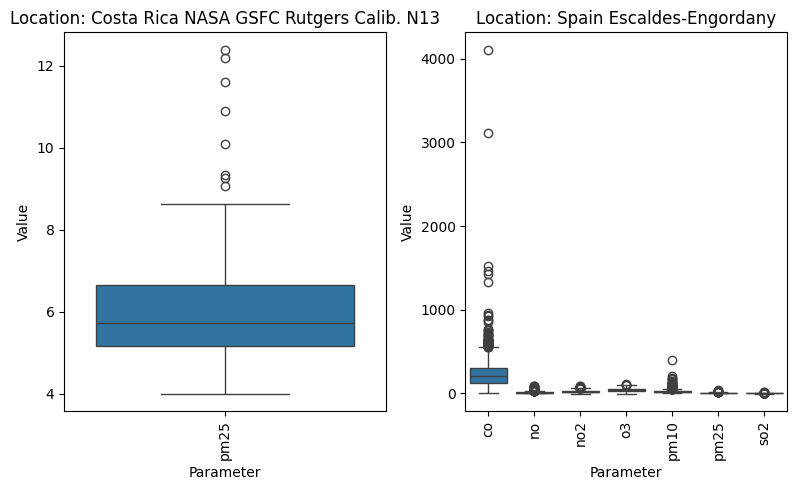

In [112]:

plt.figure(figsize=(4 * len(locations_dfs), 5))

for i, df in enumerate(locations_dfs):
    plt.subplot(1, len(locations_dfs), i + 1)
    plt.title(f"Location: {locations[i].country} {locations[i].name}")
    plt.xlabel("Parameter")
    plt.ylabel("Value")
    plt.xticks(rotation=90)
    sns.boxplot(x="parameter_name", y="value", data=df)

plt.tight_layout()
plt.show()

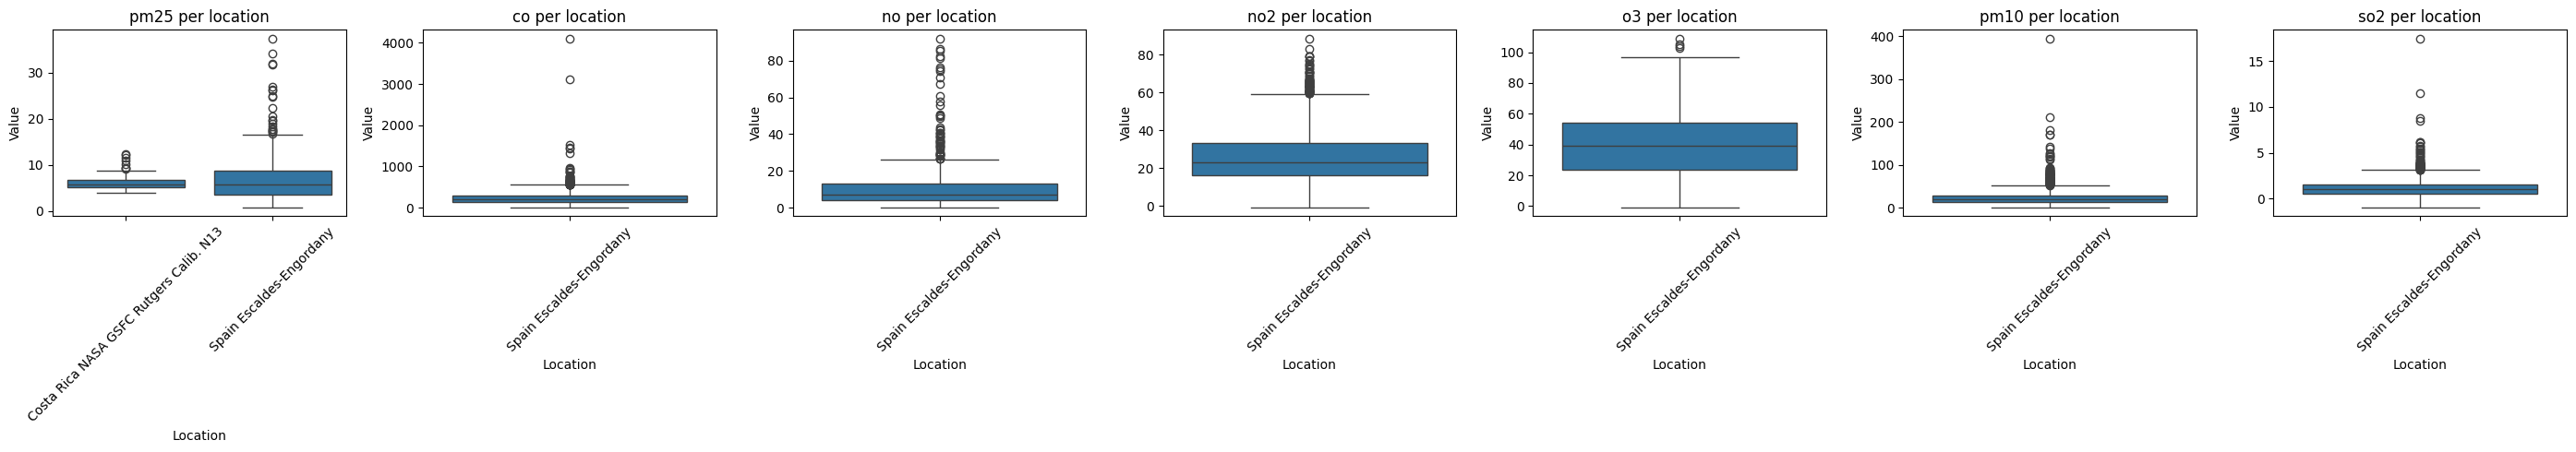

In [119]:
all_dfs = pd.concat(locations_dfs, ignore_index=True)
different_parameters = all_dfs["parameter_name"].unique()

plt.figure(figsize=(4 * 7, 5))

for i, parameter in enumerate(different_parameters):
    plt.subplot(1, 7, i + 1)
    plt.title(f"{parameter} per location")
    plt.xlabel("Location")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    sns.boxplot(x="location_name", y="value", data=all_dfs[all_dfs["parameter_name"] == parameter])

plt.tight_layout()
plt.show()


# 4. Análisis y comparación:

Se debe realizar un análisis EDA que incluya análisis univariable y multivariable.

Analizar las tendencias de los indicadores para las diferentes ciudades y hacer comparaciones entre diferentes países y ciudades.

Incluir posibles correlaciones entre las variables y parámetros de calidad del aire de cada país/ciudad.

Utilizar diferentes tipos de visualizaciones relevantes para el análisis.


### Descripción inicial de los datos

Podemos analizar los datos inicialmente con las funciones que ofrecen los pandas DF.

In [91]:
locations_dfs = [pd.read_csv(f"{location.file_path}.csv") for location in locations]


# 5. Conclusiones y Recomendaciones:

Extraer conclusiones sobre la evolución de la calidad del aire en Costa Rica y las ciudades seleccionadas, explicando cómo los datos sustentan estas conclusiones.

Buscar información sobre las políticas ambientales y regulaciones en estas ciudades y mostrar cómo los datos reflejan el efecto de estas políticas.